# 1 Keypoints

Keypoints are certain locations in the image that are very distinct and could be identified between two or more different image.

Available methods to find locally distinct points in an image include:

- Harris corner detector
- Shi-Tomasi corner detector
- Föstner operator
- Difference of Gaussians

## Corners and edges

Corners and edges are often highly distinct points.

Corners are invariant to translation, rotation and illumination.
They normally have two orthogonal edges.

## Finding corners

To find corners we need to search for intensity changes in two directions.

Compute SSD (sum of squared differences) of neighbor pixels around (x,y).

$$
f(x,y)=\underbrace{\sum_{(u,v)\in W_{xy}}}_{\text{local patch around x,y}} (I(u,v)-I(u+\delta u, v+\delta v))^2
$$

Using Taylor series we obtain:

$$I(u+\delta u, v+\delta v) \approx I(u,v) + [J_x, J_y] \begin{bmatrix}\delta u \\ \delta v\end{bmatrix}$$

Putting this term in the equation above we get:

$$f(x,y)\approx \sum_{(u,v)\in W_{xy}} (I(u,v)-I(u,v) + [J_x, J_y] \begin{bmatrix}\delta u \\ \delta v\end{bmatrix})^2$$

$$f(x,y)\approx \sum_{(u,v)\in W_{xy}} ([J_x, J_y] \begin{bmatrix}\delta u \\ \delta v\end{bmatrix})^2$$

In a matrix form:

$$f(x,y) \approx \sum_{(u,v)\in W_{xy}} \Big(\begin{bmatrix}\delta u \\ \delta v\end{bmatrix}^T \begin{bmatrix} J_x^2 & J_xJ_y \\ J_xJ_y & J_y^2\end{bmatrix} \begin{bmatrix}\delta u \\ \delta v\end{bmatrix} \Big)^2$$

We can move the sum inside the matrix.

$$f(x,y) \approx \Big(\begin{bmatrix}\delta u \\ \delta v\end{bmatrix}^T
\underbrace{
\begin{bmatrix} \sum_W J_x^2 & \sum_W J_xJ_y \\
\sum_W J_xJ_y &\sum_W J_y^2
\end{bmatrix}}_{\text{structure matrix}}
\begin{bmatrix}\delta u \\ \delta v\end{bmatrix} \Big)^2$$

Structure matrix summarizes the first derivatives of the image in a local patch and accumulates gradience.

$$M = \begin{bmatrix} \sum_W J_x^2 & \sum_W J_xJ_y \\
\sum_W J_xJ_y &\sum_W J_y^2
\end{bmatrix}$$

If we compute eigenvalues and eigenvectors of this matrix.
So it encodes the intensity changes in a local patch. It's just built from image gradience.

The Jacobians can be computed by convolving image either with Sharr or Sobel kernels:

$$
\begin{split}
J_x^2 &= (D_x * I)^2 \\
J_xJ_Y &= (D_x * I)(D_y * I) \\
J_y^2 &= (D_y * I)^2
\end{split}
$$

## Practical considerations

- RGB should be converted to gray-scale first.
- Real images are affected by noise, so smoothing of the input is suggested.

![corner detection pipeline](doc/corner_detection_pipeline.png)

## Sobel and Gaussian filter

Our first steps:
 - Load image
 - Convert it from rgb to gray-scale
 - Use Gaussian blur to reduce noise
 - Use Sobel filter to calculate derivatives along X and Y directions. 


Loaded image of size 147456


(np.float64(-0.5), np.float64(383.5), np.float64(383.5), np.float64(-0.5))

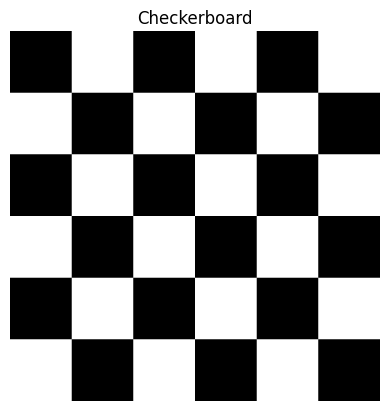

In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Load image and convert it to float32 from uint8
image = np.asarray(Image.open("data/checkerboard.png"), dtype=np.float32)

print(f"Loaded image of size {image.size}")
plt.title("Checkerboard")
plt.imshow(image, cmap='gray')
plt.axis('off')

### Gaussian filter

We convolve an image with a Gaussian kernel in order to smooth it out. It normally helps to reduce the image noise which is normally present from the camera. In our checkerboard example it is not really required. However, we'll have it for later use with real-world images.

In [2]:
def gaussian_kernel(kernel_size: int = 3, sigma: float=0.5) -> np.ndarray:
    """Generate a 2D Gaussian kernel."""

    # Generate values around zero mean with given kernel size
    half_size = (kernel_size-1) // 2
    x = np.linspace(-half_size, half_size, kernel_size)

    # Create a grid of coordinates in 2D space
    xx, yy = np.meshgrid(x,x)

    # Compute Gaussian kernel
    kernel = np.exp( -1/2 * (xx**2 + yy**2) / sigma**2)

    # Normalize kernel to sum to 1
    kernel = kernel / np.sum(kernel)

    # Make sure the returned kernel is of expected type
    return kernel.astype(np.float32)

In [ ]:

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact, IntSlider, FloatSlider

def plot_kernel(kernel_size : int =3, sigma: float = 0.5) -> None:
    """Plot a 3D surface plot of a Gaussian kernel."""

    kernel = gaussian_kernel(kernel_size, sigma)
    
    # Create coordinate grid for plotting
    x = np.linspace(-(kernel_size-1)/2, (kernel_size-1)/2, kernel_size)
    xx, yy = np.meshgrid(x, x)
    
    # Set up the 3D plot
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    surface = ax.plot_surface(xx, yy, kernel, cmap='viridis', edgecolor='none')
    
    ax.set_title(f'Gaussian Kernel: Size={kernel_size}, Sigma={sigma}')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Value')
    fig.colorbar(surface, shrink=0.5, aspect=5)
    
    plt.show()

# Create interactive sliders
interact(plot_kernel,
         kernel_size=IntSlider(min=3, max=15, step=2, value=11, description='Kernel Size'),
         sigma=FloatSlider(min=0.1, max=3.0, step=0.1, value=1.7, description='Sigma'));


interactive(children=(IntSlider(value=11, description='Kernel Size', max=15, min=3, step=2), FloatSlider(value…

Now, having the kernel, we can convolve image and blur it correspondingly.

Kernel size and sigma are related values.

If kernel is small, but sigma value is bug, kernel captures only a small part of the Gaussian.

A rule of thumb is to try to capture $\pm 2 \sigma$.

A rule of thumb therefore is a central pixel plus $\pm 2 \sigma$: $\text{kernel size} \approx 4 \sigma + 1$.

Or alternatively $\sigma \approx \frac{\text{kernel size}-1}{4}$, so for kernel size 3 reasonable starting sigma would be 0.5.

In [4]:
from scipy import ndimage

def convolve_and_display(kernel_size=3, sigma=0.5):
    kernel = gaussian_kernel(kernel_size, sigma)
    # Convolve the image with the Gaussian kernel
    filtered = ndimage.convolve(image, kernel)
    
    # Display the result
    plt.figure(figsize=(5, 5))
    plt.imshow(filtered, cmap='gray')
    plt.title(f'Convolved Image: Kernel Size = {kernel_size}, Sigma = {sigma}')
    plt.axis('off')
    plt.show()

# Create interactive sliders for kernel size and sigma
interact(convolve_and_display,
         kernel_size=IntSlider(min=3, max=15, step=2, value=3, description='Kernel Size'),
         sigma=FloatSlider(min=0.1, max=3.0, step=0.01, value=1.5, description='Sigma'));

interactive(children=(IntSlider(value=3, description='Kernel Size', max=15, min=3, step=2), FloatSlider(value=…

### Sobel filter

Sobel filter allows to efficiently approximate gradience of the image by convolving Sobel kernel with an image.


$$
D_x = \frac{1}{8}
\begin{bmatrix}
1 & 2 & 1 \\
0 & 0 & 0 \\
-1 & -2 & -1 \\
\end{bmatrix}
$$

$$
D_y = \frac{1}{8}
\begin{bmatrix}
1 & 0 & -1 \\
2 & 0 & -2 \\
1 & 0 & -1 \\
\end{bmatrix}
$$

In [5]:
def sobel_kernel_Dx() -> np.ndarray:
    """Generate a 2D Sobel kernel along X dimension."""
    return 1.0 / 8 * np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], dtype=np.float64)

def sobel_kernel_Dy() -> np.ndarray:
    """Generate a 2D Sobel kernel along Y dimension."""
    return sobel_kernel_Dx().T

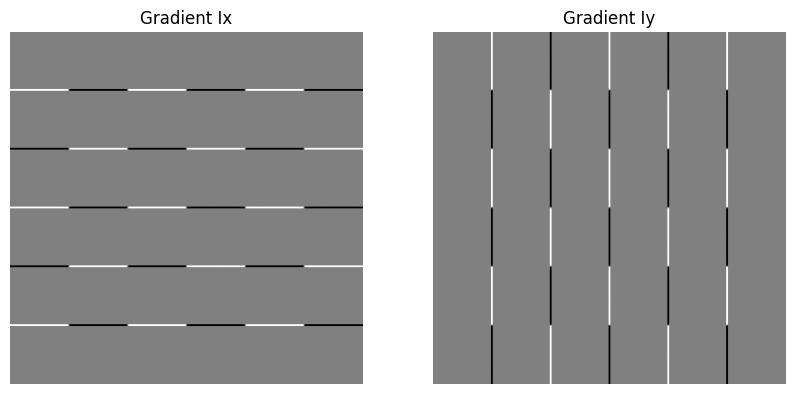

In [6]:
# Initialize Sobel kernels
Dx = sobel_kernel_Dx()
Dy = sobel_kernel_Dy()

# Compute approximate image gradients
Ix = ndimage.convolve(image, Dx)
Iy = ndimage.convolve(image, Dy)
    
# Display the gradients
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(Ix, cmap='gray')
plt.title('Gradient Ix')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(Iy, cmap='gray')
plt.title('Gradient Iy')
plt.axis('off')

plt.show()

## Combining sobel and Gaussian kernels

We can combine Gaussian and sobel kernels together to efficiently perform both operations.

In [7]:
# Prepare gaussian and Sobel kernels
G = gaussian_kernel(3, 0.5)
Dx = sobel_kernel_Dx()
Dy = sobel_kernel_Dy()

# Convolve kernels to do pre-smoothing
Kx = ndimage.convolve(G, Dx)
Ky = ndimage.convolve(G, Dy)

# Calculate image derivatives
Ix = ndimage.convolve(image, Kx)
Iy = ndimage.convolve(image, Ky)

(np.float64(-0.5), np.float64(383.5), np.float64(383.5), np.float64(-0.5))

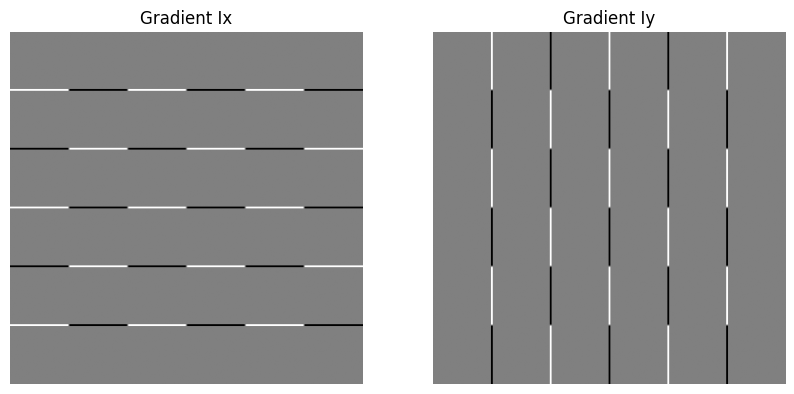

In [10]:
# Plot gradients
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(Ix, cmap='gray')
ax[0].set_title('Gradient Ix')
ax[0].axis('off')

ax[1].imshow(Iy, cmap='gray')
ax[1].set_title('Gradient Iy')
ax[1].axis('off')

We now can use computed gradients to assemble a Structure Matrix.

For each pixel, a structure matrix would be a sum of gradients around this pixel in the following form:

$$M = \begin{bmatrix} \sum_W J_x^2 & \sum_W J_xJ_y \\
\sum_W J_xJ_y &\sum_W J_y^2
\end{bmatrix}$$

Our simple checkerboard image is 384 by 384, which means we have 147.456 pixels.

For each of those pixels we need to sum elements in a window. 

For example for 3 by 3 window, we would end up with 147.465 x 9 operations = **1.327.104** operations.

So doing it Python's for loops is not a good idea.

What we are going to do instead is to pre-compute integral image.

Integral image is the same size as an original image, where starting from top left pixel (index 0, 0) every following pixel represents the sum of pixels from the top and left.

Below you can see an illustration of this concept. Table number 1 corresponds to our image, table number 2 corresponds to integral image.

Then, using simple formula, we can recover the sum for arbitrary patch in the image in constant $O(1)$ time.

The example of computation is shown below table 2 in purple.

<img src="doc/Integral_image_application_example.svg.png" height="400">

Image is courtesy of [Wikipedia](https://en.wikipedia.org/wiki/Summed-area_table).

Computing integral image is trivial in python.

(np.float64(-0.5), np.float64(383.5), np.float64(383.5), np.float64(-0.5))

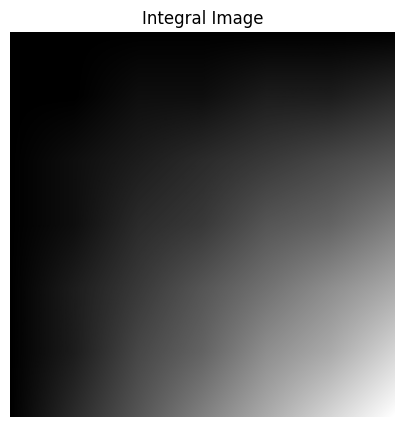

In [11]:
# Example
# Convert image to float64 for summation
image_float64 = image.astype(np.float64)

# Compute integral image fo our gradient Ix
integral_image = np.cumsum(np.cumsum(image_float64, axis=0), axis=1)

# Plot image
plt.figure(figsize=(5, 5))
plt.imshow(integral_image, cmap='gray')
plt.title('Integral Image')
plt.axis('off')

Now, given integral image, we need to compute sums for each pixels in our image. We will implement box summing function for that.

In [15]:
def box_summing(input_img, kernel_size):
    """Fast box summing convolution using integral images."""

    h, w = input_img.shape
    k = kernel_size // 2

    output = np.zeros_like(input_img, dtype=np.float64)

    integral = np.cumsum(np.cumsum(np.asarray(input_img, dtype=np.float64), axis=0), axis=1)

    for y in range(k, h - k):
        for x in range(k, w - k):
            # left x, top y
            lx, ty = x - k, y - k
            # right x, bottom y
            rx, by = x + k, y + k

            sum_value = float(integral[by, rx])
            if lx > 0:
                sum_value -= integral[by, lx - 1]
            if ty > 0:
                sum_value -= integral[ty - 1, rx]
            if lx > 0 and ty > 0:
                sum_value += integral[ty - 1, lx - 1]

            output[y, x] = sum_value

    return output


Now we can compute values of structure matrix.

Here $v_1, v_2, v_3$ correspond to values of a structure matrix.

$$
M = 
\begin{bmatrix} \sum_W J_x^2 & \sum_W J_xJ_y \\
\sum_W J_xJ_y &\sum_W J_y^2
\end{bmatrix}
=
\begin{bmatrix} v_1 & v_2 \\
 v_2 & v_3 
\end{bmatrix}
$$

In [21]:
Ix2 = Ix**2
Iy2 = Iy**2
IxIy = Ix*Iy

kernel_size = 3
v1 = box_summing(Ix2, kernel_size)
v2 = box_summing(IxIy,kernel_size)
v3 = box_summing(Iy2, kernel_size)

(np.float64(-0.5), np.float64(383.5), np.float64(383.5), np.float64(-0.5))

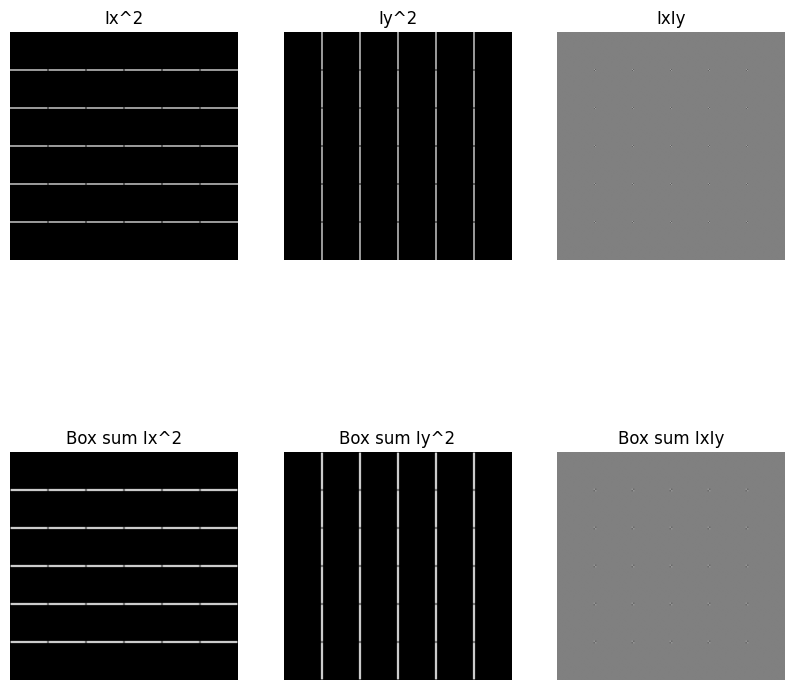

In [23]:
fig, ax = plt.subplots(2, 3, figsize=(10, 10))

ax[0, 0].imshow(Ix2, cmap='gray')
ax[0, 0].set_title('Ix^2')
ax[0, 0].axis('off')

ax[0, 1].imshow(Iy2, cmap='gray')
ax[0, 1].set_title('Iy^2')
ax[0, 1].axis('off')

ax[0, 2].imshow(IxIy, cmap='gray')
ax[0, 2].set_title('IxIy')
ax[0, 2].axis('off')

ax[1, 0].imshow(v1, cmap='gray')
ax[1, 0].set_title('Box sum Ix^2')
ax[1, 0].axis('off')

ax[1, 1].imshow(v3, cmap='gray')
ax[1, 1].set_title('Box sum Iy^2')
ax[1, 1].axis('off')

ax[1, 2].imshow(v2, cmap='gray')
ax[1, 2].set_title('Box sum IxIy')
ax[1, 2].axis('off')

## Harris corner detector

It tries to separate good and bad points.

Harris corner criterion
$$R=det(M)-k(trace(M))^2 =\lambda_1\lambda_2-k(\lambda_1+\lambda_2)^2$$

with

$|R|\approx 0 \Rightarrow \lambda_1 \approx \lambda_2 \approx 0$: flat region

$R \lt 0 \Rightarrow \lambda_1 \gg \lambda_2 \, \text{or} \, \lambda_2 \gg \lambda_1$: edge

$R \gg 0 \Rightarrow \lambda_1 \approx \lambda_2 \gg 0$: corner

The weighting factor $k$ is normally $k \in [0.01, 0.06]$

<img src="doc/harris_regions.png" height="400">

Image is a courtesy of Cyrill Stachniss


In [24]:
k = 0.04
R = v1*v3 - v2**2 - k*(v1+v3)**2

In R, it the corners can already be seen as a very strong (white) response.

(np.float64(-0.5), np.float64(383.5), np.float64(383.5), np.float64(-0.5))

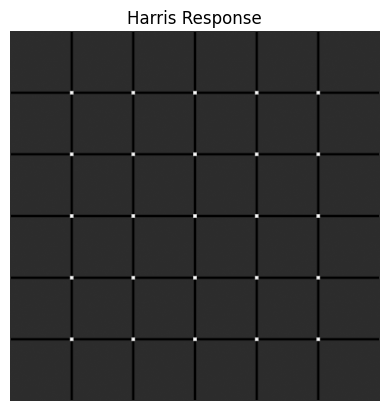

In [26]:
plt.imshow(R, cmap='gray')
plt.title('Harris Response')
plt.axis('off')

However, if we zoom in around corner, we can see that we still detect a lot of them. Hence we want to minimize amount of strong responses of the neighborhood of a corner and only take the strongest.

Extracting strongest response in the neighborhood is called **Non-Maximum Suppression (NMS)** and we will implement it for our case next.

(np.float64(-0.5), np.float64(99.5), np.float64(99.5), np.float64(-0.5))

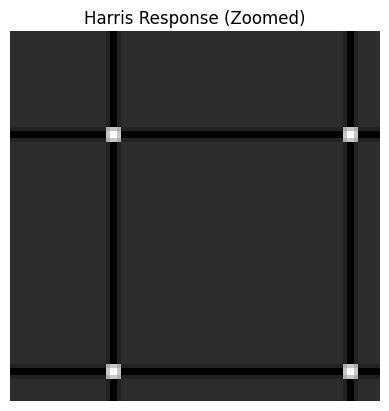

In [28]:
# Zoom in on the corner
plt.imshow(R[100:200, 100:200], cmap='gray')
plt.title('Harris Response (Zoomed)')
plt.axis('off')

In [29]:
from scipy.ndimage import maximum_filter

def nms_2d(scores, neighborhood_size=3):
    """
    Performs non-maximum suppression on a 2D score array.
    
    Parameters:
        scores (2D array): Input score map (higher values are kept).
        neighborhood_size (int): Suppression window size.

    Returns:
        suppressed_scores (2D array): Scores after NMS.
    """

    # Find local maxima using a max filter
    # max_filter is a function that replaces each element in an array with the local maximum value
    # within a given neighborhood.
    # We then compare scores with the maximum values, this produces a mask of True values at local maxima
    # and False elsewhere.
    max_mask = (scores == maximum_filter(scores, size=neighborhood_size, mode='constant', cval=0))

    # Suppress all but local maxima
    # by multiplying local maxima with True (1) and other values with False (0)
    suppressed_scores = scores * max_mask

    return suppressed_scores


(np.float64(-0.5), np.float64(99.5), np.float64(99.5), np.float64(-0.5))

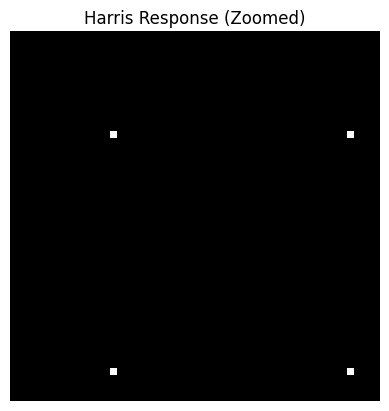

In [30]:
R_suppressed = nms_2d(R, 3)
plt.imshow(R_suppressed[100:200, 100:200], cmap='gray')
plt.title('Harris Response (Zoomed)')
plt.axis('off')

### Thresholding

Finally we need to decide on a threshold on which values would constitute a corner and which would not.

There are few options available:

- Manually specified absolute value: such approach would work best if we fine-tune for a concrete image, but it doesn't scale
- Relative global thresholding: we can find maximum value in the image and select threshold for the whole image as a relative value
- Relative local thresholding (Otsu's method): we can select relative threshold, but in a certain window

We will continue with second approach.

In [31]:
# Define threshold as 30% of the score range
T = (R_suppressed.max() - R_suppressed.min()) * 0.3

# Find corner coordinates and stack them together
# this produces an array of shape [N, 2] where N is the number of corners
corners = np.column_stack(np.where(R_suppressed>T))
print(corners.shape)

(100, 2)


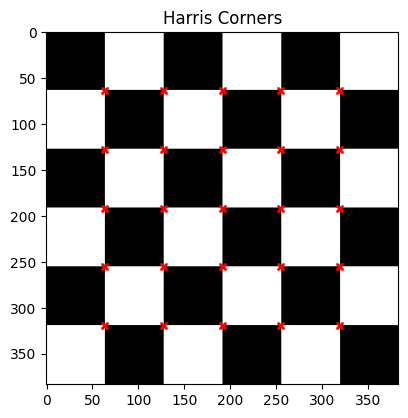

In [36]:
# Finally, let's plot the corners in the original image
fig = plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.title("Harris Corners")
plt.imshow(image, cmap='gray')
plt.plot(corners[:,1], corners[:,0], 'rx', markersize=5)

## Shi-Tomasi Corner Detector

Shi-Tomasi criterion is now de-facto standard and it is normally used by default.


$$\lambda_{min}(M) = \frac{trace(M)}{2}-\frac{1}{2}\sqrt{(trace(M)^2-4det(M))}$$

$\lambda_{min}(M) \ge T$: corner

<img src="doc/shi-tomasi-regions.png" width=400>

Reminder, structure matrix:

$$
M = 
\begin{bmatrix} \sum_W J_x^2 & \sum_W J_xJ_y \\
\sum_W J_xJ_y &\sum_W J_y^2
\end{bmatrix}
=
\begin{bmatrix} v_1 & v_2 \\
 v_2 & v_3 
\end{bmatrix}
$$

In [41]:
trace = v1 + v3
det = v1 * v3 - v2**2

R = trace / 2.0 - 0.5 * np.sqrt(trace**2 - 4 * det)

(np.float64(-0.5), np.float64(99.5), np.float64(99.5), np.float64(-0.5))

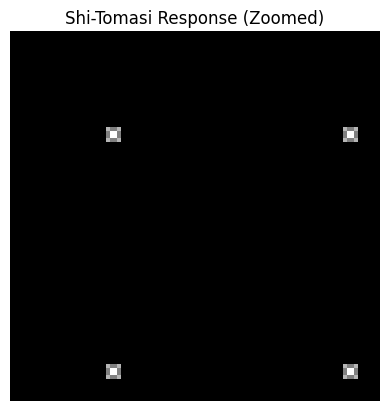

In [42]:
# Zoom in on the corner
plt.imshow(R[100:200, 100:200], cmap='gray')
plt.title('Shi-Tomasi Response (Zoomed)')
plt.axis('off')

(np.float64(-0.5), np.float64(99.5), np.float64(99.5), np.float64(-0.5))

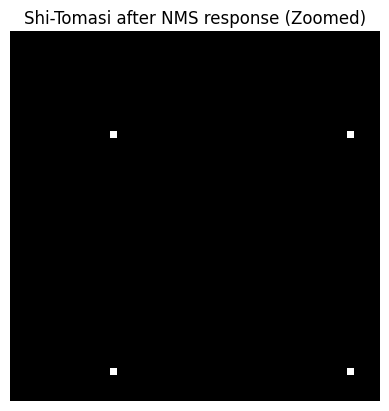

In [43]:
R_suppressed = nms_2d(R, 3)
plt.imshow(R_suppressed[100:200, 100:200], cmap='gray')
plt.title('Shi-Tomasi after NMS response (Zoomed)')
plt.axis('off')

In [44]:
# Define threshold as 30% of the score range
T = (R_suppressed.max() - R_suppressed.min()) * 0.3

# Find corner coordinates and stack them together
# this produces an array of shape [N, 2] where N is the number of corners
corners = np.column_stack(np.where(R_suppressed>T))
print(corners.shape)

(100, 2)


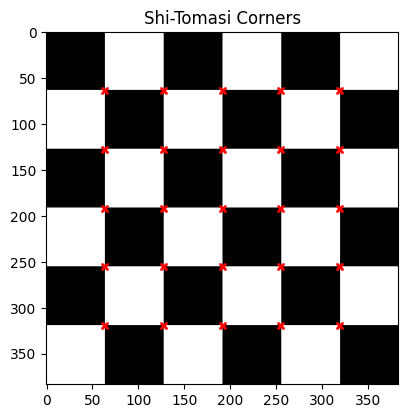

In [45]:
fig = plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.title("Shi-Tomasi Corners")
plt.imshow(image, cmap='gray')
plt.plot(corners[:,1], corners[:,0], 'rx', markersize=5)